In [74]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms, models

try:
    from apex.fp16_utils import *
    from apex import amp, optimizers
    from apex.multi_tensor_apply import multi_tensor_applier
except ImportError:
    raise ImportError("Please install apex from https://www.github.com/nvidia/apex to run this example.")

In [75]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
#device = torch.device('cpu')

In [76]:
#!git clone https://github.com/jaddoescad/ants_and_bees.git
#Slow, I don't know why. Just do this from the terminal...

In [77]:
#transform = transforms.Compose([transforms.ToTensor(), 
#                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#                               ])

# Training data set receives "augmentation" to make the data more challenging:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomHorizontalFlip(),
                                #transforms.RandomRotation(10),
                                transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                transforms.ColorJitter(brightness=1, contrast=1, saturation=1), #1 better than 0.2 for this dataset
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])

transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])


training_dataset = datasets.ImageFolder('ants_and_bees/train', transform=transform_train)
validation_dataset = datasets.ImageFolder('ants_and_bees/val', transform=transform)



# USED TO LOAD OUR TRAINING DATA BATCHES
#training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=1000, shuffle=True, num_workers=10)
#validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1000, shuffle=False, num_workers=10)
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=20, shuffle=False)

In [78]:
print(len(training_dataset))
print(len(validation_dataset))
# small dataset b/c we are using transfer learning, and the bulk of the training has already been completed

244
153


In [79]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    #print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

In [80]:
classes = ('ant', 'bee')
print(classes)

('ant', 'bee')


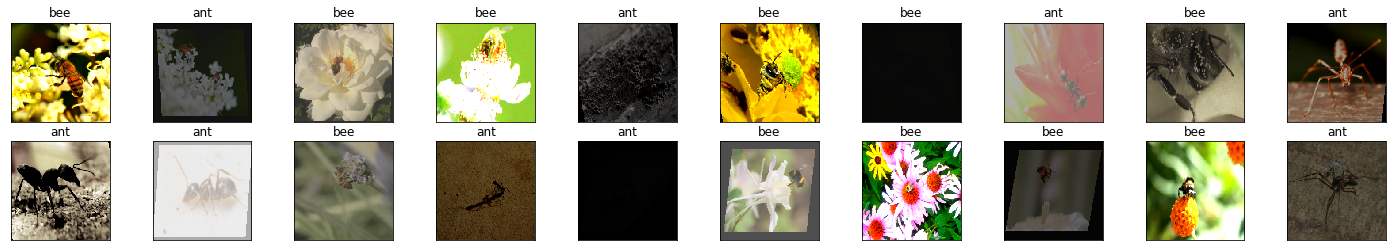

In [81]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [82]:
#model = models.alexnet(pretrained=True)
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Mirrorshades/.cache\torch\checkpoints\vgg16-397923af.pth
4.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

11.5%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

18.7%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub

In [83]:
#model = LeNet().to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [84]:
for param in model.features.parameters():
    param.requires_grad = False #Freezes parameters to prevent calculating gradients, saves time!

In [85]:
import torch.nn as nn
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [86]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [87]:
# had to install Nvidia Apex for FP16 calculations
#model, optimizer = amp.initialize(model, optimizer, opt_level='O1')

In [96]:
epochs = 10
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0  
    
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
 #       inputs = inputs.view(inputs.shape[0], -1) # Must flatten image to do mat mult: 1, 784 --> NO LONGER NEED TO FLATTEN
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        #with amp.scale_loss(loss, optimizer) as scaled_loss: 
        #    scaled_loss.backward() 
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                #val_inputs = val_inputs.view(val_inputs.shape[0], -1) # Must flatten image to do mat mult: 1, 784
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
            
        epoch_loss = running_loss/len(training_loader.dataset) #divide by total number of images to get p(x)
        epoch_acc = running_corrects.float()/len(training_loader.dataset) #divide by total number of images to get p(x)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
        
        val_epoch_loss = val_running_loss/len(validation_loader.dataset) #divide by total number of images to get p(x)
        val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset) #divide by total number of images to get p(x)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        
        print('epoch:', (e+1))
        print('training loss: {:.4f}, {:.4f}'.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

epoch: 1
training loss: 0.0103, 0.8975
validation loss: 0.0149, 0.9346
epoch: 2
training loss: 0.0091, 0.9057
validation loss: 0.0183, 0.9412
epoch: 3
training loss: 0.0082, 0.9221
validation loss: 0.0203, 0.9281
epoch: 4
training loss: 0.0089, 0.9344
validation loss: 0.0224, 0.9346
epoch: 5
training loss: 0.0137, 0.9180
validation loss: 0.0233, 0.9281
epoch: 6
training loss: 0.0103, 0.9098
validation loss: 0.0211, 0.9281
epoch: 7
training loss: 0.0067, 0.9344
validation loss: 0.0260, 0.9346
epoch: 8
training loss: 0.0073, 0.9016
validation loss: 0.0199, 0.9412
epoch: 9
training loss: 0.0074, 0.9139
validation loss: 0.0300, 0.9020
epoch: 10
training loss: 0.0073, 0.9221
validation loss: 0.0307, 0.9281
epoch: 11
training loss: 0.0085, 0.9303
validation loss: 0.0263, 0.9150
epoch: 12
training loss: 0.0085, 0.9385
validation loss: 0.0255, 0.9346
epoch: 13
training loss: 0.0143, 0.9016
validation loss: 0.0227, 0.9085
epoch: 14
training loss: 0.0089, 0.9262
validation loss: 0.0248, 0.9216
e

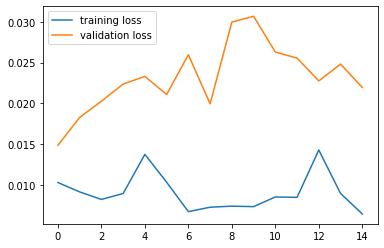

In [97]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

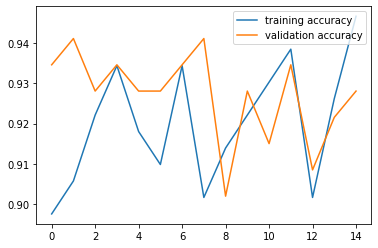

In [98]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

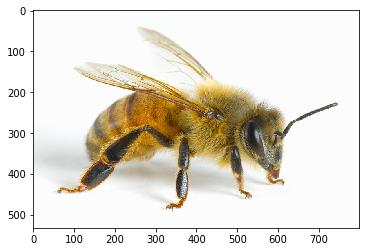

In [99]:
import requests
from PIL import ImageOps
from PIL import Image
#url = 'https://giecdn.azureedge.net/storage/fileuploads/image/2019/07/03/istock_ant_good.jpg?w=736&h=414&mode=crop'
url = 'https://media.npr.org/assets/img/2018/06/07/gettyimages-200415242-001_slide-d26f3af782b697f15ceebe2f7c380c0e545dd47b-s800-c85.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

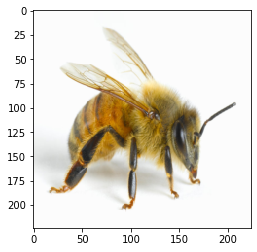

In [100]:
img = transform(img)
plt.imshow(im_convert(img))

In [101]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

bee


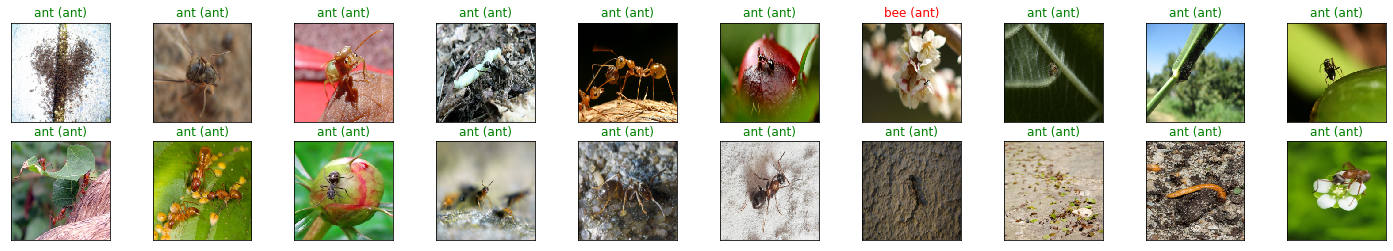

In [102]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
#images_ = images.view(images.shape[0], -1)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color = ("green" if preds[idx]==labels[idx] else "red"))

In [95]:
#CIFAR issues:
# overfitting
# low accuracy
# slow